# HMM Training
train and save hmms on rin-filtered, rin and top 3 PC regressed myconnectome data

In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%load_ext version_information
%version_information numpy, scipy, matplotlib, pandas,

Software versions
Python 2.7.12 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 5.1.0
OS Linux 4.4.0 59 generic x86_64 with debian stretch sid
numpy 1.11.1
scipy 0.18.1
matplotlib 1.5.3
pandas 0.19.2
Thu Feb 02 21:05:09 2017 EST

In [103]:
# Standard library imports
import os
import sys
sys.path.append("../src/")  # 

# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pomegranate import HiddenMarkovModel, NormalDistribution
import json
from sklearn.preprocessing import scale

In [3]:
# Plot styles
%matplotlib inline
sns.set()

# HMM Training

## Description
Train and monitor training of various HMMs used throughout the analyses in other notebooks

### Initialization Approaches

1. <b>Dispersed Mean Initialization</b> Distribute the means of the states about 0, learn variance and 
2. <b>K-Means on Data Initialization</b> Initialize k state hmm with kmeans over partitions of observations
3. <b> K-Means on Gaussian Laws Initialization</b> An alternative kmeans initialization https://www.gipsa-lab.grenoble-inp.fr/~bertrand.rivet/.../RivetEUSIPCO2011a.pdf

### Procedure
Set up the models and train them on seperate processes, we'll save the intermediates every 500 iterations, so that we can restart on a new process if we run out of time.

Well use 7 states for each model


## Data

In [90]:
data_file = '../data/varstab_data_prefiltered_rin6_filtered_rin_3PC_regressed.txt'
data = pd.read_csv(data_file, index_col=0)

In [108]:
norm_data = pd.DataFrame(data=scale(data, axis=1, with_mean=True, with_std=True), index=data.index, columns=data.columns)

## Dispersed Mean Initialization

In [87]:
k = 7
r = 500000
normal = np.sort(np.random.randn(k * r))

In [88]:
means = [normal[x*r:(x+1)*r].mean() for x in range(k)]
variances = [normal[x*r:(x+1)*r].var() for x in range(k)]
print means
print variances

[-1.5796124379454533, -0.79925255794272365, -0.36799996793109541, 0.00057054900261211902, 0.36800548013583273, 0.7990375677334558, 1.5793575326938043]
[0.19175209806509683, 0.020696835557628041, 0.012327108312970094, 0.010732205692539763, 0.012253249649746114, 0.02066757964845551, 0.19145025620059125]


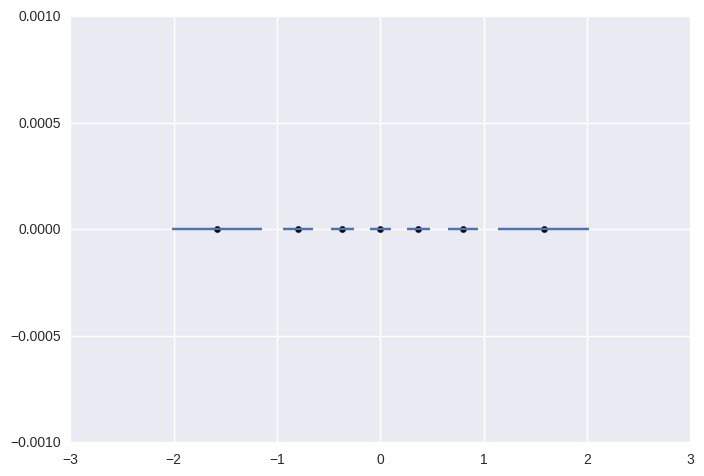

In [89]:
fig, ax = plt.subplots()
ax.errorbar(means, np.zeros_like(means), xerr=np.sqrt(variances), linestyle='None')
ax.scatter(means, np.zeros_like(means), color='k')

In [118]:
dists = [NormalDistribution(mu, sig2) for mu, sig2 in zip(means, variances)]
starts = np.full(len(dists), fill_value=(float(1) / len(dists)), dtype=float)
trans_mat = np.full((len(dists), len(dists)), fill_value=(0.5 / (len(dists) - 1)))
np.fill_diagonal(trans_mat, 0.5)

model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts)

Now we train the model, save the intermediates every 1000 iterations so that we have something to work with if this doesn't go to completion

In [ ]:
if not os.path.isdir('../data/n7_hmm'):
    os.makedirs('../data/n7_hmm')
for i in range(1000):
    improvement = model.fit(data.as_matrix(), max_iterations=1, n_jobs=1, verbose=False)
    model_json = model.to_json()
    save_to = '../data/n7_hmm/model.%d' %i
    current = '../data/n7_hmm/model.current'
    improvement_log = '../data/n7_hmm/training.log'
    with open(save_to, 'w') as outfile:
        json.dump(model_json, outfile)
    with open(current, 'w') as outfile:
        json.dump(model_json, outfile)
    with open(improvement_log, 'a') as logfile:
        logfile.write('%d: %f\n' %(i, improvement))

In [1]:
model

NameError: name 'model' is not defined

In [8]:
data

,sub002,sub007,sub009,sub010,sub013,sub016,sub019,sub022,sub025,sub026,...,sub086,sub088,sub091,sub093,sub094,sub095,sub097,sub099,sub101,sub104
A1BG-AS1,-3.880618,-0.055755,6.250915,1.105000,-4.128192,2.605814,2.173644,2.176763,0.349681,3.867299,...,-4.635940,-5.834398,-5.835263,-0.744600,-2.837982,2.970382,-0.456083,-0.748305,-2.676508,-2.984366
A2M,0.548169,0.788180,-0.794834,4.282475,-0.010618,-1.155847,1.222960,1.517263,-1.863958,1.739862,...,-0.053006,-2.128065,-0.672776,0.507328,-0.896663,-1.152376,1.297726,-0.218265,-2.906367,-0.153398
AAAS,-5.466889,-2.934023,2.457833,-2.045715,-7.761330,3.877890,-3.214474,-4.744269,-9.710887,-3.647570,...,9.483918,-0.704603,-6.815650,-1.628457,-0.988680,5.945961,-4.770564,0.831031,1.491971,7.596002
AACS,9.652737,8.373747,0.259966,-0.384558,0.304474,2.149173,-0.932333,-0.231656,-9.909250,-7.886865,...,2.270008,3.121277,5.709794,-5.071251,3.102246,-1.777990,1.457166,8.224743,-0.453078,-7.111128
AAED1,-1.262476,6.175814,-6.168919,-3.240297,-3.474439,3.884185,-0.873846,3.708299,1.232868,3.177528,...,5.415848,0.638661,-1.779541,4.149636,-3.374807,2.042367,4.140903,4.845769,3.275120,-3.946532
AAGAB,11.467465,3.169814,7.800162,19.665411,-3.759587,0.973191,6.770227,-3.581397,2.497986,-2.493599,...,2.787265,-0.488037,2.455197,1.422594,1.568897,-5.052262,-11.915233,7.400074,-9.343352,-14.554699
AAK1,11.322871,3.949985,-0.861449,-3.792018,-0.364975,-10.011077,-0.732808,2.634066,-2.896001,-1.981091,...,-1.873728,2.006930,4.332535,3.455812,0.622775,4.885694,3.586280,-2.713122,2.380616,6.127070
AAMDC,4.180288,3.970697,-1.359416,3.162774,-2.123726,2.746674,4.994319,4.831810,-4.145997,9.342093,...,5.482112,0.637895,-7.776020,-1.757575,-2.601496,-0.450200,-5.462100,4.839447,-3.362739,-5.392482
AAMP,-10.013075,4.461860,1.554001,5.774487,2.244408,2.048723,0.202103,-2.093150,-0.995669,5.568018,...,0.036136,-4.682304,-0.128757,-2.864225,-4.319042,0.378593,-3.034363,4.137902,-1.748489,-7.070756
AANAT,-0.244144,0.992314,2.963308,3.369326,-0.648500,-0.924256,0.368604,3.512222,-2.041656,0.189482,...,5.173179,2.689442,-1.333002,-9.391430,-4.746269,-4.511886,1.305917,1.267606,1.982320,1.879242
